In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import glob
import getpass
import importlib
import functions
import spectrogram_plotting_functions
import scipy.signal
importlib.reload(functions)
importlib.reload(spectrogram_plotting_functions)

<module 'spectrogram_plotting_functions' from 'c:\\Users\\Thomas\\Desktop\\cpl_analysis_naman\\spectrogram_plotting_functions.py'>

## 02 Loading the folder that contains our data

In [3]:

user= (getpass.getuser())
print("Hello", user)

base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat\\*.mat')
savepath = base+'\\results\\'
print(files)

Hello Thomas
['C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk1_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk3_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk5_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230529_dk6_nocontext.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk1_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk3_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk5_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230531_dk6_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230609_dk1_BW_nocontext_day1.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230609_dk3_BW_nocontext_day1.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230610_dk1_BW_nocontext_day2.mat', 'C:\\Users\\Thomas\\Dropbox\\CPLab\\all_data_mat\\20230610_dk3_BW_noconte

In [4]:
keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'}

In [5]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#files=['C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk1_nocontext.mat']
event_data_df=[]

events_codes_all = {}
before_data_power_df=pd.DataFrame(columns=['rat_id','task','channel_id','before_data_power','before_data_spec'])
averaged_data=pd.DataFrame(columns=['rat_id','task','channel_id','average_power_spectrum'])
averaged_data_welch=pd.DataFrame(columns=['rat_id','task','channel_id','average_power_spectrum'])

for file in files:
    #if 'dk6' in file:
        print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        print(date, rat_id, task)

        f = h5py.File(file, 'r')
        channels = list(f.keys())
        print(channels)

        if 'Keyboard' in channels:
            events = f['Keyboard']
        elif 'keyboard' in channels:
            events = f['keyboard']
        elif 'memory' in channels:
            events = f['memory']
        elif 'Memory' in channels:
            events = f['Memory']

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = functions.generate_epochs_with_first_event(events_codes, events_times)

        first_event = events_times[0]
        for channeli in channels:
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                print(raw_data.shape, raw_time.shape, sampling_rate)
                notch_filtered_data = functions.iir_notch(raw_data, sampling_rate, 60)

                normalized_data, time, data_before = functions.data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
                
                # This makes a dataframe for calculating baseline power 
                bd_freq, bd_power = scipy.signal.welch(data_before,fs=2000.0, nperseg=512)
                #before_data_power=functions.calculate_power_1D(data_before)
                delta_f = bd_freq[1] - bd_freq[0]
                before_data_power = np.sum(bd_power) * delta_f
                
                before_data_row=pd.DataFrame({
                    'rat_id':[rat_id],'task':[task],'channel_id':[channel_id],'before_data_power':[before_data_power],'before_data_spec':[bd_power]})
                before_data_power_df=pd.concat([before_data_power_df,before_data_row],ignore_index=True)
                
                
                total = normalized_data
                compiled_data = []
                power_spectra = []
                
                compiled_data_welch = []
                power_spectra_welch = []

                
                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    print(door_timestamp, trial_type, dig_timestamp, dig_type)
                    data_complete_trial = functions.extract_complete_trial_data(total, time, door_timestamp, dig_timestamp, sampling_rate)
                    
                    #Here we will extract and store the events data
                    data_door_before,data_door_after=functions.extract_door_data(total, time, door_timestamp, sampling_rate)    
                    data_dig_before, data_dig_after=functions.extract_dig_data(total,time, dig_timestamp, sampling_rate)
                    event_data_list=[data_door_before,data_door_after,data_dig_before,data_dig_after]
                    event_time=np.linspace(0,2,2*sampling_rate)
                    event_row=[]
                    event_row.append(rat_id)
                    event_row.append(task)
                    event_row.append(channeli)
                    event_row.append(i)

                    for event_data in event_data_list:
                        faxis, Sxx_event = scipy.signal.welch(event_data,sampling_rate,nperseg=1024)
                        event_row.append(np.abs(Sxx_event))
                        event_row.append(np.abs(faxis))

                    event_data_df.append(event_row)
                    faxis, Sxx = functions.frequency_domain(data_complete_trial, time)
                    f_w,sxx_w=scipy.signal.welch(data_complete_trial,sampling_rate,nperseg=1024)
                    compiled_data.append([i, faxis, Sxx])
                    power_spectra.append(Sxx)

                    compiled_data_welch.append([i, f_w, sxx_w])
                    power_spectra_welch.append(sxx_w)
                

                compiled_data_df = pd.DataFrame(compiled_data, columns=['Trial', 'Frequency Axis', 'Power Spectrum'])
                compiled_data_df_welch = pd.DataFrame(compiled_data_welch, columns=['Trial', 'Frequency Axis', 'Power Spectrum'])

                print(compiled_data_df.shape)

                # Ensure all power spectra have the same length
                min_length = min(len(spectrum) for spectrum in power_spectra)
                power_spectra = [spectrum[:min_length] for spectrum in power_spectra]

                min_length = min(len(spectrum) for spectrum in power_spectra_welch)
                power_spectra_welch = [spectrum[:min_length] for spectrum in power_spectra_welch]

                # Calculate the average power spectrum
                power_spectra = np.array(power_spectra)
                average_power_spectrum = np.mean(power_spectra, axis=0)
                row=pd.DataFrame({
                    'rat_id':rat_id,
                    'task':task,
                    'channel_id':channel_id,
                    'average_power_spectrum':[average_power_spectrum]
                })
                averaged_data=pd.concat([averaged_data,row])

                # Calculate the average power spectrum
                power_spectra_welch = np.array(power_spectra_welch)
                average_power_spectrum_welch = np.mean(power_spectra_welch, axis=0)
                row=pd.DataFrame({
                    'rat_id':rat_id,
                    'task':task,
                    'channel_id':channel_id,
                    'average_power_spectrum':[average_power_spectrum_welch]
                })
                averaged_data_welch=pd.concat([averaged_data_welch,row])

event_data_compiled_df = pd.DataFrame(event_data_df, columns=['rat_id','task','channel_id','trial','door before','door before freqs', 'door after','door after freqs', 'dig before','dig before freqs', 'dig after','dig after freqs'])


C:\Users\Thomas\Dropbox\CPLab\all_data_mat\20230529_dk1_nocontext.mat
20230529 dk1 nocontext
20230529 dk1 nocontext
['Keyboard', 'LFP1_AON', 'LFP1_vHp', 'LFP2_AON', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Ref', 'Respirat', 'file']
(1516022,) (1516022,) 2000
notch filter applied
normalizing data
49.0
181.20385499999998 120.0 182.713855 49.0


C:\Users\Thomas\AppData\Local\Temp\ipykernel_148756\3486359271.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  before_data_power_df=pd.concat([before_data_power_df,before_data_row],ignore_index=True)


4000 4000
4000 4000
48.0
237.771855 120.0 239.46185499999999 48.0
4000 4000
4000 4000
49.0
279.551855 120.0 280.29184999999995 49.0
4000 4000
4000 4000
48.0
348.953855 120.0 349.84385 48.0
4000 4000
4000 4000
49.0
466.78984999999994 120.0 468.25985499999996 49.0
4000 4000
4000 4000
49.0
526.9038549999999 120.0 528.223855 49.0
4000 4000
4000 4000
49.0
570.771855 120.0 571.4418549999999 49.0
4000 4000
4000 4000
48.0
617.237855 120.0 618.4178549999999 48.0
4000 4000
4000 4000
49.0
669.49786 120.0 670.737855 49.0
4000 4000
4000 4000
49.0
705.3358549999999 120.0 706.5758549999999 49.0
4000 4000
4000 4000
(10, 3)
(1516022,) (1516022,) 2000
notch filter applied
normalizing data
49.0
181.20385499999998 120.0 182.713855 49.0
4000 4000
4000 4000
48.0
237.771855 120.0 239.46185499999999 48.0
4000 4000
4000 4000
49.0
279.551855 120.0 280.29184999999995 49.0
4000 4000
4000 4000
48.0
348.953855 120.0 349.84385 48.0
4000 4000
4000 4000
49.0
466.78984999999994 120.0 468.25985499999996 49.0
4000 4000
4

In [11]:
print(len(event_data_df[0]))

12


Baseline power for individual tasks

C:\Users\Thomas\AppData\Local\Temp\ipykernel_148756\3727351795.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_df['channel_id'] = task_df['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
C:\Users\Thomas\AppData\Local\Temp\ipykernel_148756\3727351795.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_df['channel_id'] = task_df['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )
C:\Users\Thomas\AppData\Local\Temp\ipykernel_148756\3727351795.py:10: SettingWithCopyWarning: 
A v

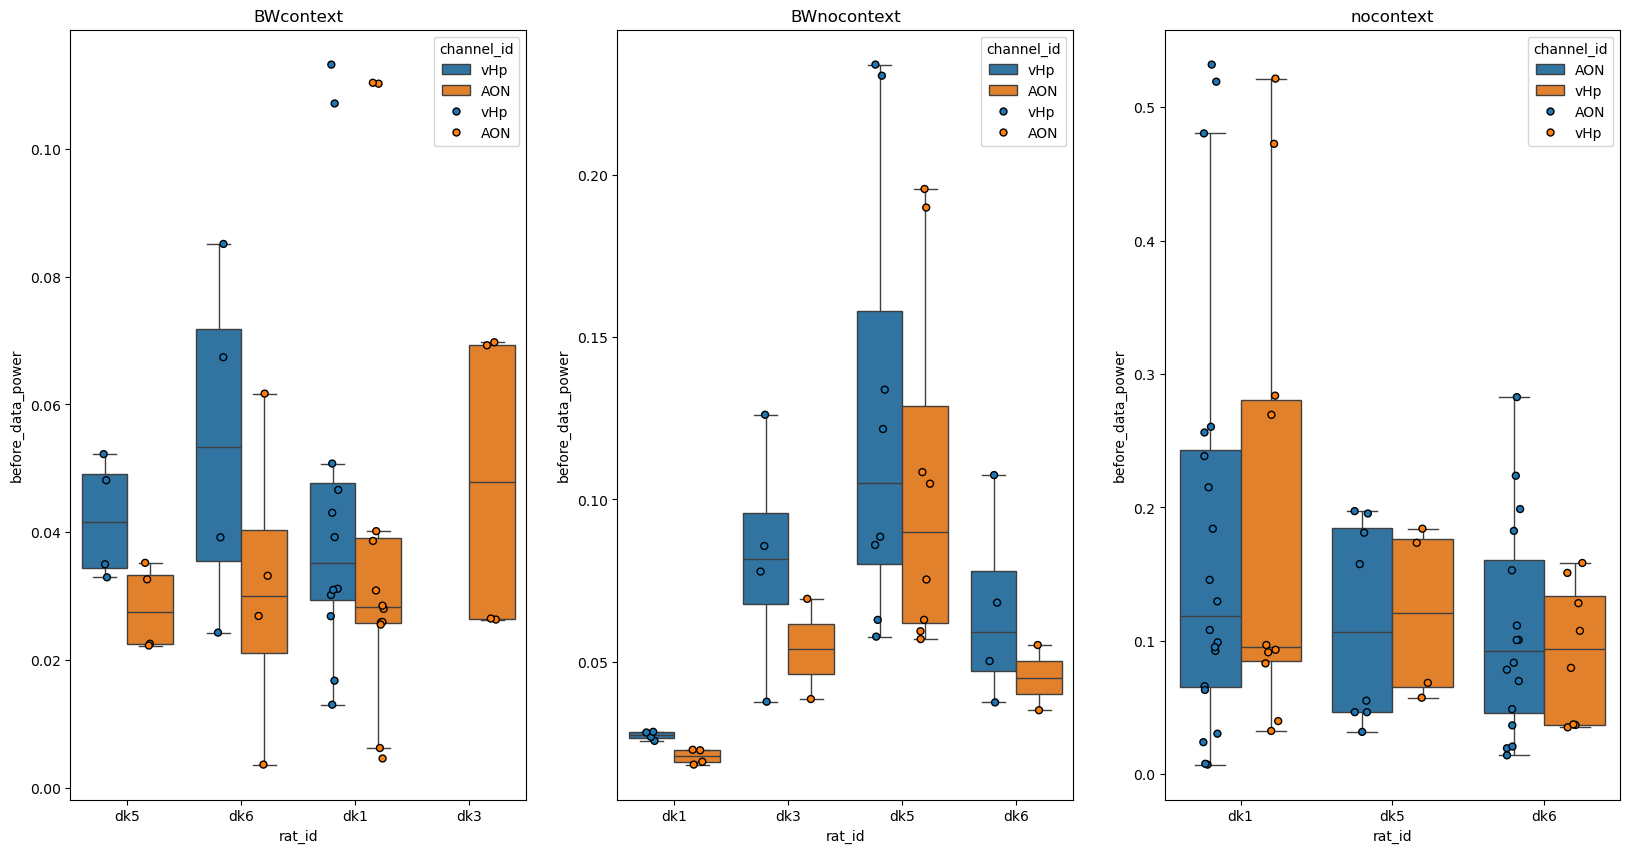

In [6]:
import seaborn as sns
brain_areas = ['AON', 'vHp']
tasks = np.unique(before_data_power_df['task'])

fig,axs=plt.subplots(nrows=1, ncols=3, figsize=(20,10))
axs=axs.flatten()
for i,task in enumerate(tasks):
    task_dict={}
    task_df=before_data_power_df[before_data_power_df['task']==task]
    task_df['channel_id'] = task_df['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
    task_df['channel_id'] = task_df['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )
    rat_ids = np.unique(task_df['rat_id'])

    for rat in rat_ids:
        task_dict[rat]=np.array(task_df[task_df['rat_id']==rat]['before_data_power'])
    
    # Convert task_dict to a DataFrame
    task_df_csv = pd.DataFrame.from_dict(task_dict, orient='index').transpose()
    
    # Save the DataFrame as a CSV file
    task_df_csv.to_csv(os.path.join(savepath,f'task_{task}_baseline_power.csv'), index=False)
    
    #Plotting the thing
    ax=axs[i]
    sns.boxplot(x=task_df['rat_id'], y=task_df['before_data_power'],showfliers=False, hue=task_df['channel_id'],ax=ax)
    sns.stripplot(x=task_df['rat_id'], y=task_df['before_data_power'], hue=task_df['channel_id'],ax=ax, jitter=True, dodge=True,edgecolor='black',linewidth=1)

    ax.set_title(f'{task}')
#fig.savefig(os.path.join(savepath,'baselinepower_indtask.png'),format='png',dpi=300, bbox_inches='tight')

baseline power for individual rat

C:\Users\Thomas\AppData\Local\Temp\ipykernel_148756\2882263254.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
C:\Users\Thomas\AppData\Local\Temp\ipykernel_148756\2882263254.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )
C:\Users\Thomas\AppData\Local\Temp\ipykernel_148756\2882263254.py:10: SettingWithCopyWarning: 
A value

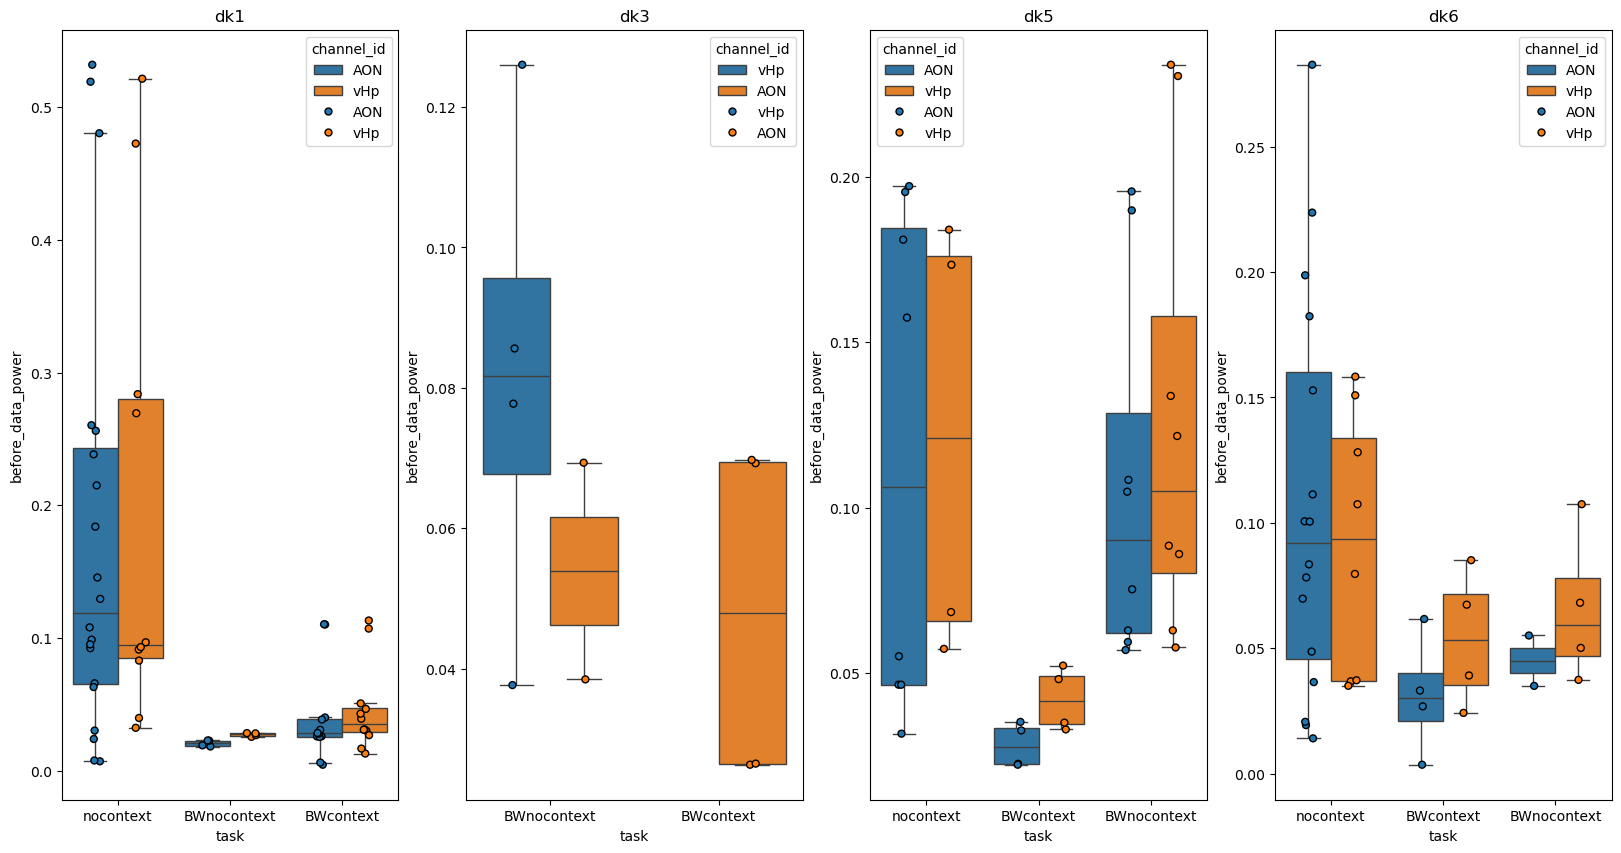

In [7]:
import seaborn as sns
brain_areas = ['AON', 'vHp']
rats = np.unique(before_data_power_df['rat_id'])

fig,axs=plt.subplots(nrows=1, ncols=len(rats), figsize=(20,10))
axs=axs.flatten()
for i,rat in enumerate(rats):
    rat_dict={}
    rat_df=before_data_power_df[before_data_power_df['rat_id']==rat]
    rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
    rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )
    tasks = np.unique(rat_df['task'])

    for task in tasks:
        rat_dict[task]=np.array(rat_df[rat_df['task']==task]['before_data_spec'])
    
    # Convert task_dict to a DataFrame
    rat_df_csv = pd.DataFrame.from_dict(rat_dict, orient='index').transpose()
    
    # Save the DataFrame as a CSV file
    rat_df_csv.to_csv(os.path.join(savepath,f'task_{rat}_baseline_power.csv'), index=False)
    
    #Plotting the thing
    ax=axs[i]
    sns.boxplot(x=rat_df['task'], y=rat_df['before_data_power'],showfliers=False, hue=rat_df['channel_id'],ax=ax)
    sns.stripplot(x=rat_df['task'], y=rat_df['before_data_power'], hue=rat_df['channel_id'],ax=ax, jitter=True, dodge=True,edgecolor='black',linewidth=1)

    ax.set_title(f'{rat}')
fig.savefig(os.path.join(savepath,'baselinepower_indrat.png'),format='png',dpi=300, bbox_inches='tight')

Baseline power spectrum for individual rat

C:\Users\Thomas\AppData\Local\Temp\ipykernel_148756\2377974564.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
C:\Users\Thomas\AppData\Local\Temp\ipykernel_148756\2377974564.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )
C:\Users\Thomas\AppData\Local\Temp\ipykernel_148756\2377974564.py:10: SettingWithCopyWarning: 
A value

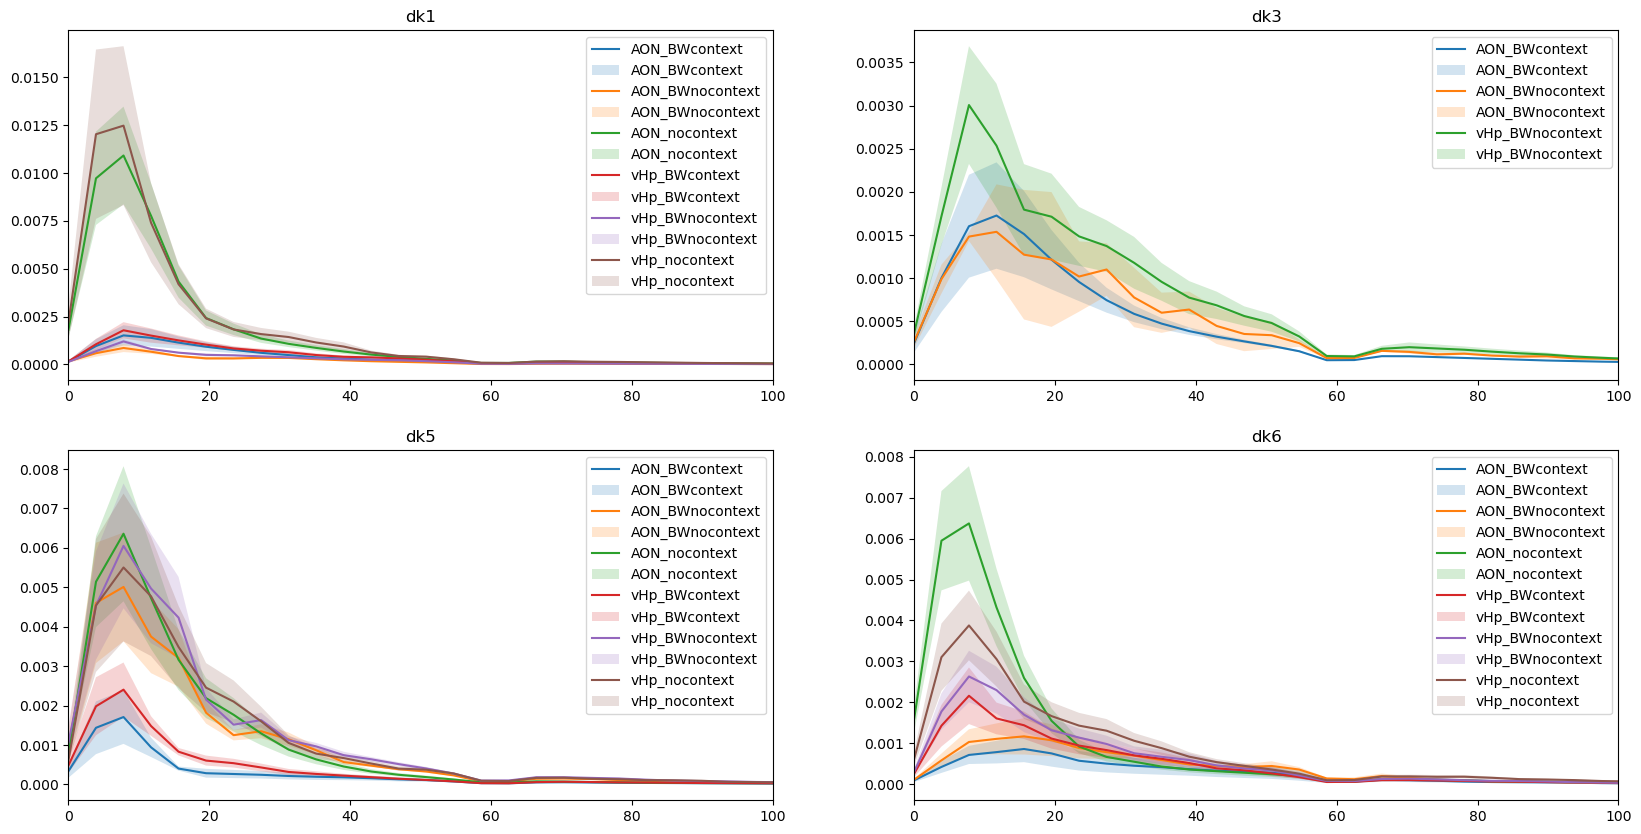

In [9]:
import seaborn as sns
brain_areas = ['AON', 'vHp']
rats = np.unique(before_data_power_df['rat_id'])

fig,axs=plt.subplots(nrows=2, ncols=2, figsize=(20,10))
axs=axs.flatten()
for i,rat in enumerate(rats):
    rat_dict={}
    rat_df=before_data_power_df[before_data_power_df['rat_id']==rat]
    rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
    rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )
    tasks = np.unique(rat_df['task'])
    for area in brain_areas:
        for task in tasks:
            rat_df_task=rat_df[(rat_df['task']==task) & (rat_df['channel_id']==area)]['before_data_spec']
            if not rat_df_task.empty:
                rat_baseline_power=np.mean(np.abs(rat_df_task))
                rat_baseline_sem=scipy.stats.sem(np.abs(rat_df_task))
                rat_dict[f'{area}_{task}_mean']=rat_baseline_power
                rat_dict[f'{area}_{task}_sem']=rat_baseline_sem

                faxis=np.linspace(0,1000,len(rat_baseline_power))
                ax=axs[i]
                ax.plot(faxis, rat_baseline_power, label=f'{area}_{task}')
                ax.fill_between(faxis,rat_baseline_power-rat_baseline_sem,rat_baseline_power+rat_baseline_sem, label=f'{area}_{task}', alpha=0.2)
    ax.set_xlim([0,100])
    ax.legend()    
    ax.set_title(f'{rat}')
    rat_df_csv = pd.DataFrame.from_dict(rat_dict, orient='index').transpose()
    rat_df_csv.to_csv(os.path.join(savepath,f'rat_{rat}_baseline_power.csv'), index=False)
#fig.savefig(os.path.join(savepath,'baselinepower_spectrum.png'),format='png',dpi=300, bbox_inches='tight')

averaged power spectrum, complete trial, ind rat

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define colorblind-friendly and printer-friendly color scheme
color_scheme = {
    'AON': ['#E69F00', '#56B4E9', '#009E73', '#F0E442'],
    'vHp': ['#0072B2', '#D55E00', '#CC79A7', '#999999']
}
averaged_data=averaged_data_welch

brain_areas = ['AON', 'vHp']
rat_ids = np.unique(averaged_data['rat_id'])
tasks = np.unique(averaged_data['task'])

for rat in rat_ids:
    rat_data = averaged_data[averaged_data['rat_id'] == rat]

    fig, ax = plt.subplots(figsize=(20, 10))

    for i, task in enumerate(tasks):
        task_data = rat_data[rat_data['task'] == task]
        task_data = task_data.reset_index(drop=True)
        task_data_vhp = task_data[task_data['channel_id'].str.contains('vHp')]
        task_data_aon = task_data[task_data['channel_id'].str.contains('AON')]
        task_data_vhp = task_data_vhp.reset_index(drop=True)
        task_data_aon = task_data_aon.reset_index(drop=True)

        color_aon = color_scheme['AON'][i % len(color_scheme['AON'])]
        color_vhp = color_scheme['vHp'][i % len(color_scheme['vHp'])]

        if not task_data_vhp.empty:
            # Ensure all power spectra have the same length
            min_length_vhp = min(len(spectrum) for spectrum in task_data_vhp['average_power_spectrum'])
            task_data_vhp_spectra = [spectrum[:min_length_vhp] for spectrum in task_data_vhp['average_power_spectrum']]
            task_data_vhp_mean = np.mean(task_data_vhp_spectra, axis=0)
            
            faxis=np.linspace(0,1000,num=len(task_data_vhp_mean))

            ax.plot(faxis,task_data_vhp_mean, label=f'vHp_{task}', color=color_vhp, linestyle='--')

        if not task_data_aon.empty:
            # Ensure all power spectra have the same length
            min_length_aon = min(len(spectrum) for spectrum in task_data_aon['average_power_spectrum'])
            task_data_aon_spectra = [spectrum[:min_length_aon] for spectrum in task_data_aon['average_power_spectrum']]
            task_data_aon_mean = np.mean(task_data_aon_spectra, axis=0)
            faxis=np.linspace(0,1000,num=len(task_data_aon_mean))
            ax.plot(faxis, task_data_aon_mean, label=f'AON_{task}', color=color_aon)

    ax.set_xlim(0, 100)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    ax.set_title(f'Average Power Spectrum by Task and Brain Area for rat {rat}')
    ax.legend()
    #fig.savefig(os.path.join(savepath,f'average_power_spectrum_complete_trial_{rat}.png'), dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
!pip install xlsxwriter

## Now we will make averaged power spectrum around events for each rat

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

brain_areas = ['AON', 'vHp']
rat_ids = np.unique(event_data_compiled_df['rat_id'])
# rat_ids = ['dk1']
events_list = ['door before', 'door after', 'dig before', 'dig after']

for rat in rat_ids:
    writer = pd.ExcelWriter(os.path.join(savepath,f'{rat} average power spectrum around events.xlsx'), engine='xlsxwriter')

    rat_data = event_data_compiled_df[event_data_compiled_df['rat_id'] == rat]
    rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
    rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )

    # # Calculate door norm by individual
    # rat_data['door norm by ind'] = rat_data['door after'] - rat_data['door before']
    
    # # Calculate the mean of the entire 'door before' column
    # mean_door_before = rat_data['door before'].mean()
    # rat_data['door norm by mean'] = rat_data['door after'] - mean_door_before
    
    fig, axs = plt.subplots(2, 2, figsize=(20, 20), sharey=True, sharex=True)
    fig.suptitle(f'{rat} event power spectrum')
    axs = axs.flatten()
    
    for event_num, event in enumerate(events_list):
        average_event_power_spectrum_df=pd.DataFrame()

        events_data = rat_data[['rat_id', 'channel_id', 'task', 'trial', event]]
        tasks = np.unique(events_data['task'])
        ax = axs[event_num]
        ax.set_title(f'{event}')
        
        #test case
        #tasks=['nocontext']
        for i, task in enumerate(tasks):
            
            task_data = events_data[events_data['task'] == task]
            task_data = task_data.reset_index(drop=True)
            task_data_vhp = task_data[task_data['channel_id'].str.contains('vHp')]
            task_data_aon = task_data[task_data['channel_id'].str.contains('AON')]
            task_data_vhp = task_data_vhp.reset_index(drop=True)
            task_data_aon = task_data_aon.reset_index(drop=True)

            if not task_data_vhp.empty:
                task_data_vhp_mean = np.mean(task_data_vhp[event], axis=0)
                task_data_vhp_sem=scipy.stats.sem(task_data_vhp[event], axis=0)

                faxis = np.linspace(0, 1000, num=len(task_data_vhp_mean))

                ax.plot(faxis, task_data_vhp_mean, label=f'vHp_{task}', linestyle='--')
                ax.fill_between(faxis, task_data_vhp_mean-task_data_vhp_sem,task_data_vhp_mean+task_data_vhp_sem, alpha=0.2, label=f'vHp_{task}_sem')
            if not task_data_aon.empty:
                task_data_aon_mean = np.mean(task_data_aon[event], axis=0)
                task_data_aon_sem=scipy.stats.sem(task_data_aon[event], axis=0)

                faxis = np.linspace(0, 1000, num=len(task_data_aon_mean))

                ax.plot(faxis, task_data_aon_mean, label=f'AON_{task}')

                ax.fill_between(faxis, task_data_aon_mean-task_data_aon_sem,task_data_aon_mean+task_data_aon_sem, alpha=0.2, label=f'AON_{task}_sem')
            
            average_event_power_spectrum_df[f'vHp_{task}']=task_data_vhp_mean
            average_event_power_spectrum_df[f'AON_{task}']=task_data_aon_mean
        average_event_power_spectrum_df.insert(0,'frequency',faxis)
        average_event_power_spectrum_df.to_excel(writer, sheet_name=event)
        ax.set_xlim(0, 100)
        ax.legend()
    writer.close()
    fig.savefig(os.path.join(savepath, f'average_power_spectrum_around_events_{rat}.png'),dpi=300, bbox_inches='tight')
    plt.show()

This code produces a plot that compares each averaged channel before and after door for each rat

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming event_data_compiled_df is already defined and contains the necessary data
brain_areas = ['AON', 'vHp']
tasks=np.unique(event_data_compiled_df['task'])
print(tasks)
rat_ids = np.unique(event_data_compiled_df['rat_id'])
# rat_ids = ['dk1']
events_list = ['door before', 'door after', 'dig before', 'dig after']
fig, axs=plt.subplots(nrows=6,ncols=4, figsize=(20,22))
rat_num=0
for rat in rat_ids:
    
    rat_data = event_data_compiled_df[event_data_compiled_df['rat_id'] == rat]
    ax_num=0
    for area in brain_areas:
        area_data=rat_data[rat_data['channel_id'].str.contains(area)]
        for task in tasks:
            ax=axs[ax_num,rat_num]
            task_data=area_data[area_data['task']==task]
            if not task_data.empty:
                task_data_before=np.mean(task_data['door before'],axis=0)
                task_data_before_sem=scipy.stats.sem(task_data['door before'], axis=0)
                
                task_data_after=np.mean(task_data['door after'],axis=0)-task_data_before
                task_data_after_sem=scipy.stats.sem(task_data['door after'], axis=0)

                task_dig_before=np.mean(task_data['dig before'],axis=0)-task_data_before
                task_dig_before_sem=scipy.stats.sem(task_data['dig before'], axis=0)

                faxis = np.linspace(0, 1000, num=len(task_data_after))
                
                #ax.plot(faxis, task_data_before, label='door before', color='grey')
                #ax.fill_between(faxis, task_data_before-task_data_before_sem,task_data_before+task_data_before_sem,alpha=0.2, color='grey')
                ax.plot(faxis, task_data_after, label='door_after - door_before',color='red')
                ax.fill_between(faxis, task_data_after-task_data_after_sem,task_data_after+task_data_after_sem,alpha=0.2, color='red')

                ax.plot(faxis, task_dig_before, label='dig_before - door_before',color='green')
                ax.fill_between(faxis, task_dig_before-task_dig_before_sem,task_dig_before+task_dig_before_sem,alpha=0.2, color='green')


                ax.legend()
                ax.set_xlim(0, 100)
                ax.set_title(f'{rat} {area} {task}')
            ax_num=ax_num+1
    rat_num=rat_num+1
    print(rat_num)
plt.show()





Averaged power spectrum of door_after and dig_before, normalized by door_before, for individual rats (all tasks in one plot)

C:\Users\sinha\AppData\Local\Temp\ipykernel_30988\3428861689.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rat_data['channel_id'] = rat_data['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
C:\Users\sinha\AppData\Local\Temp\ipykernel_30988\3428861689.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rat_data['channel_id'] = rat_data['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )


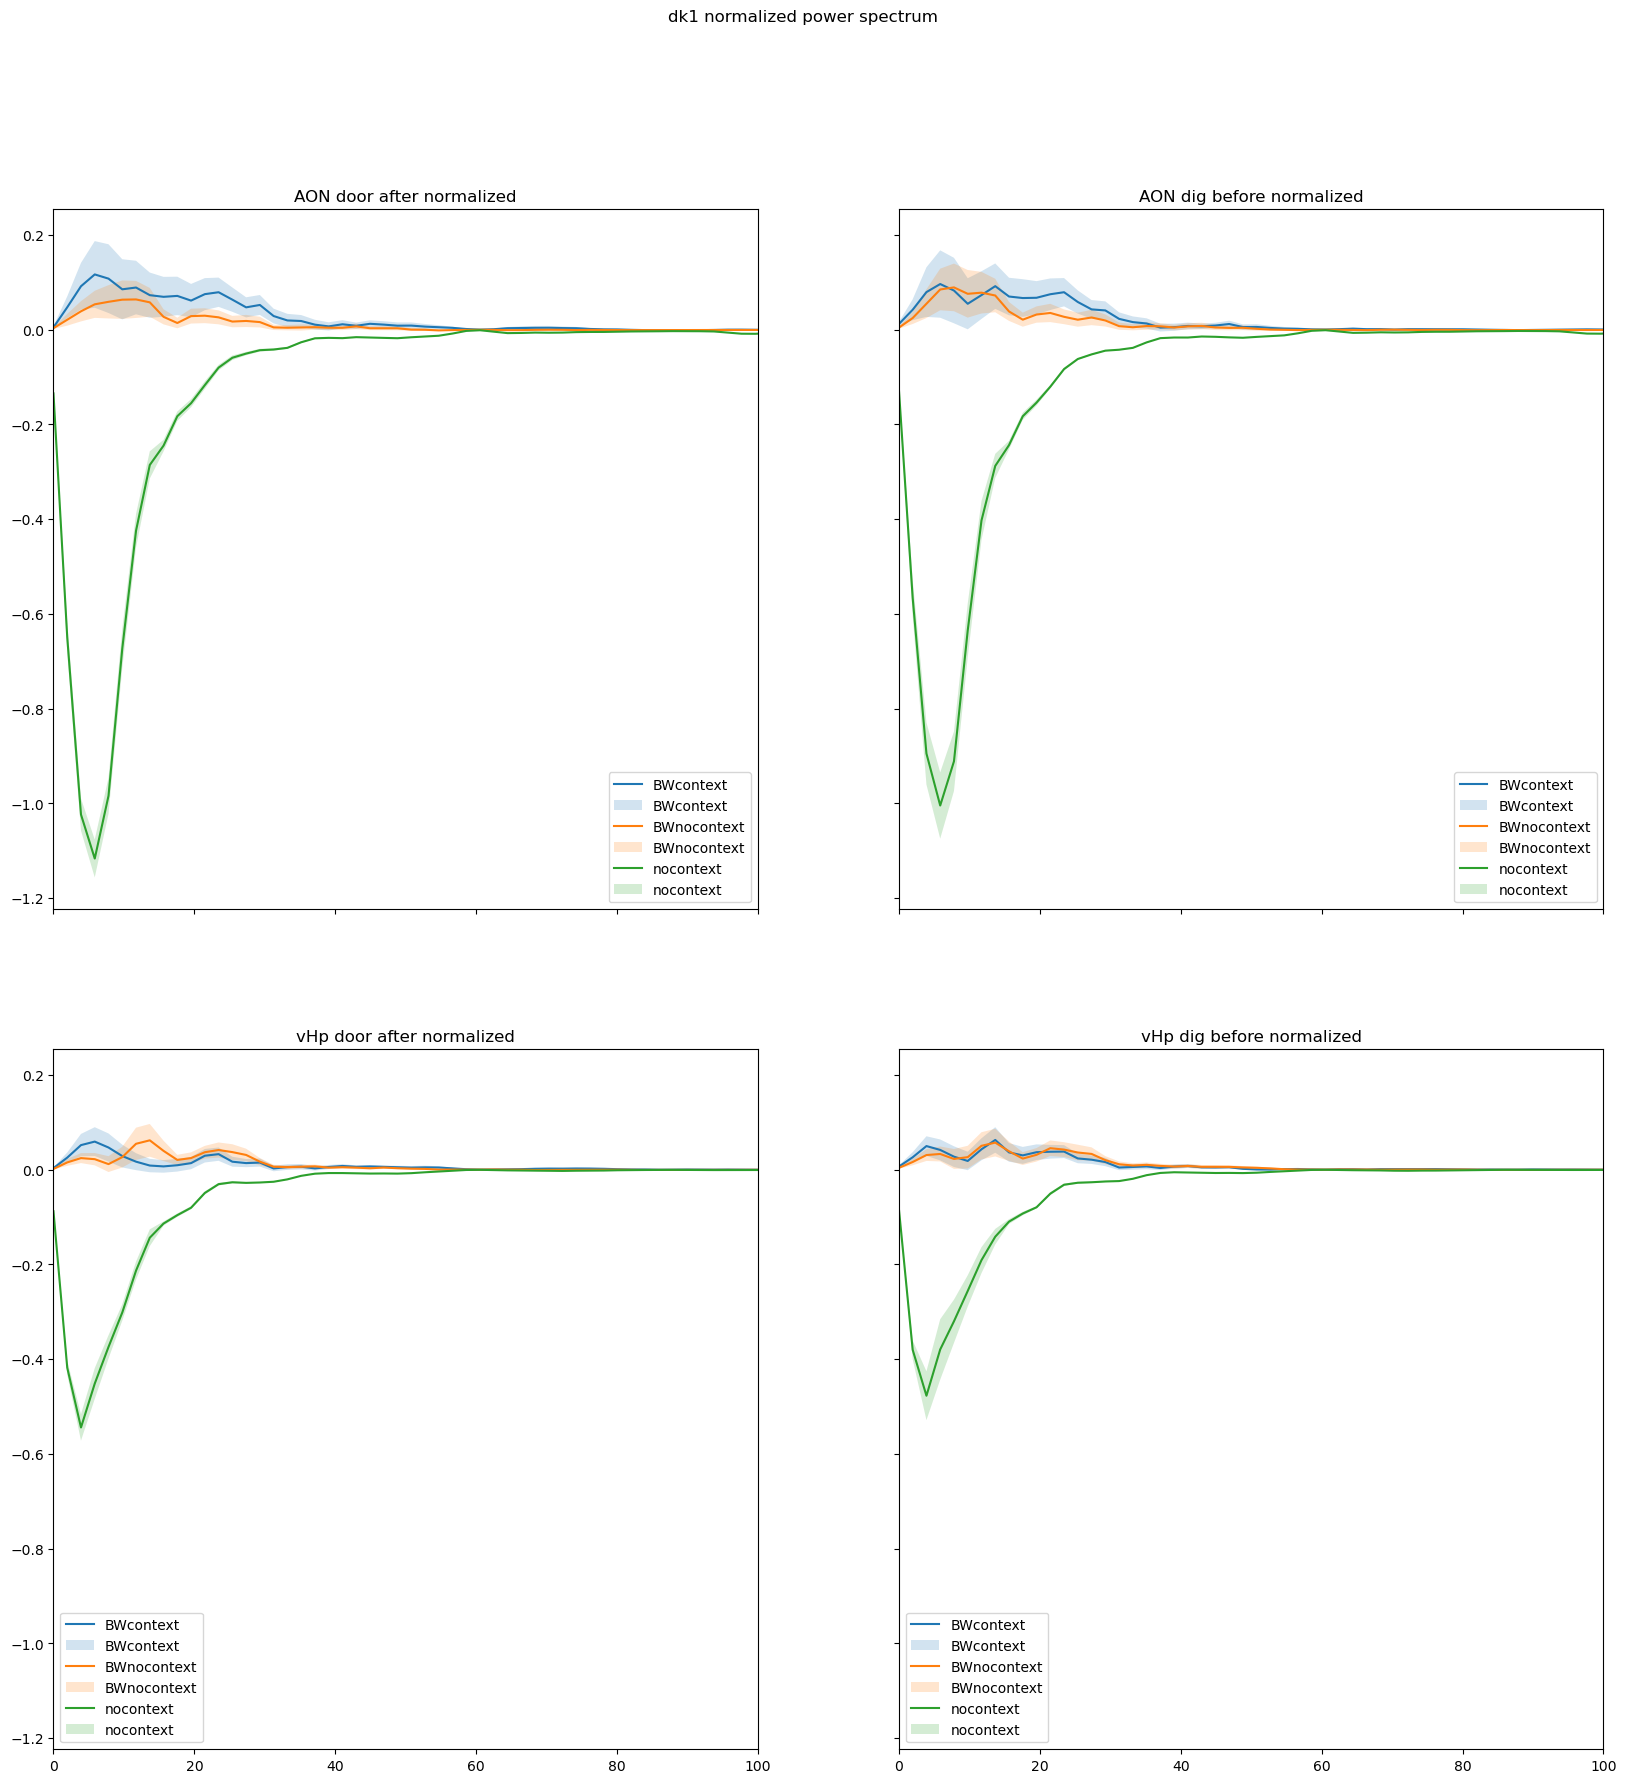

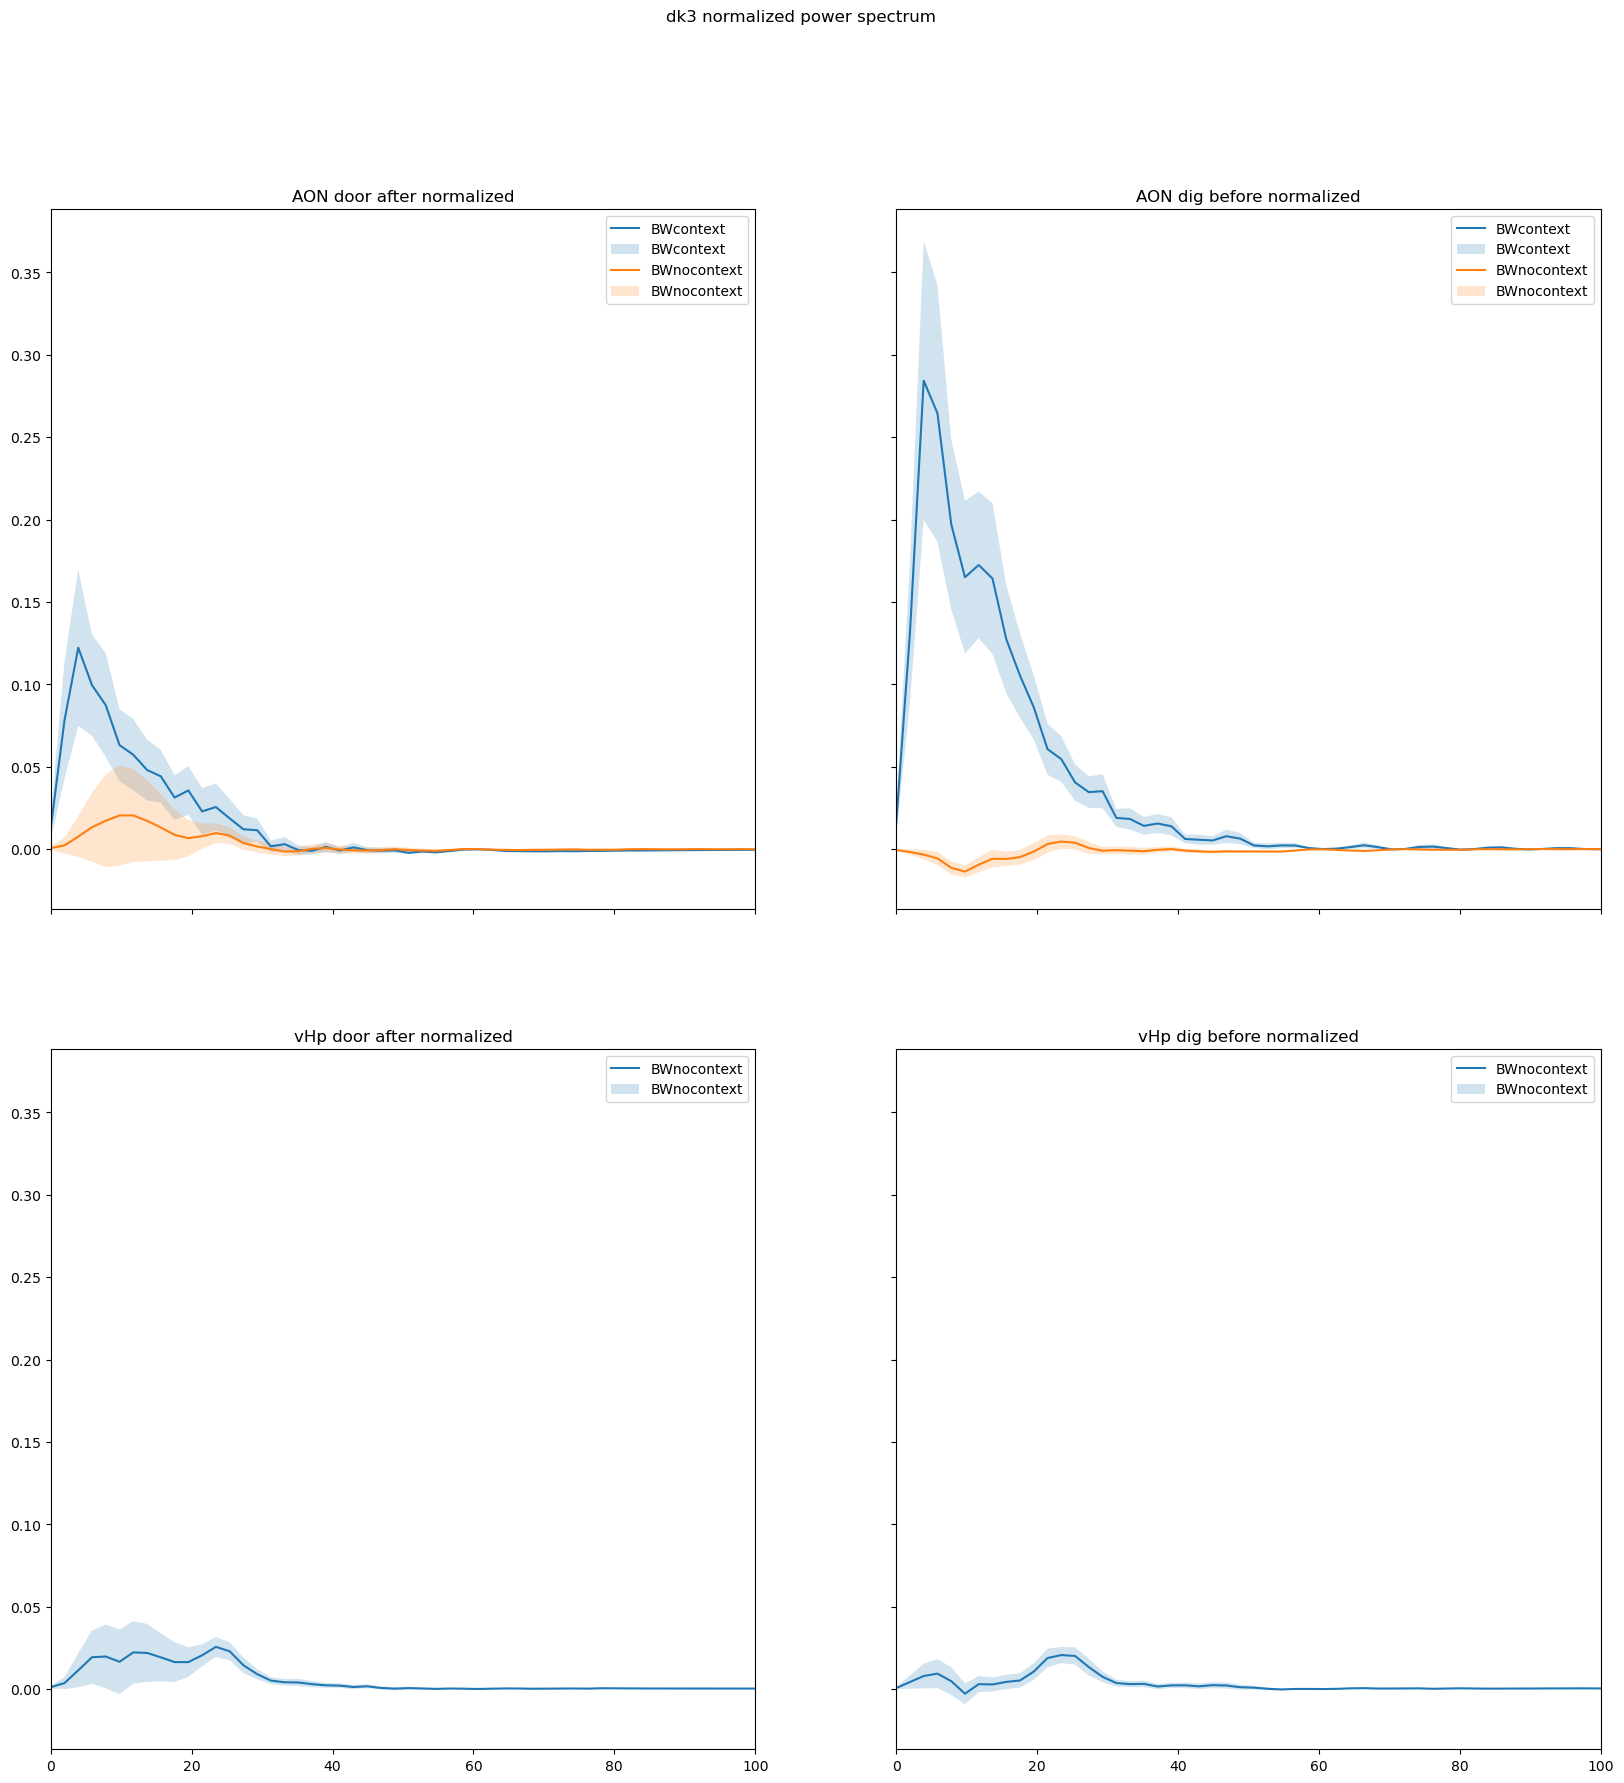

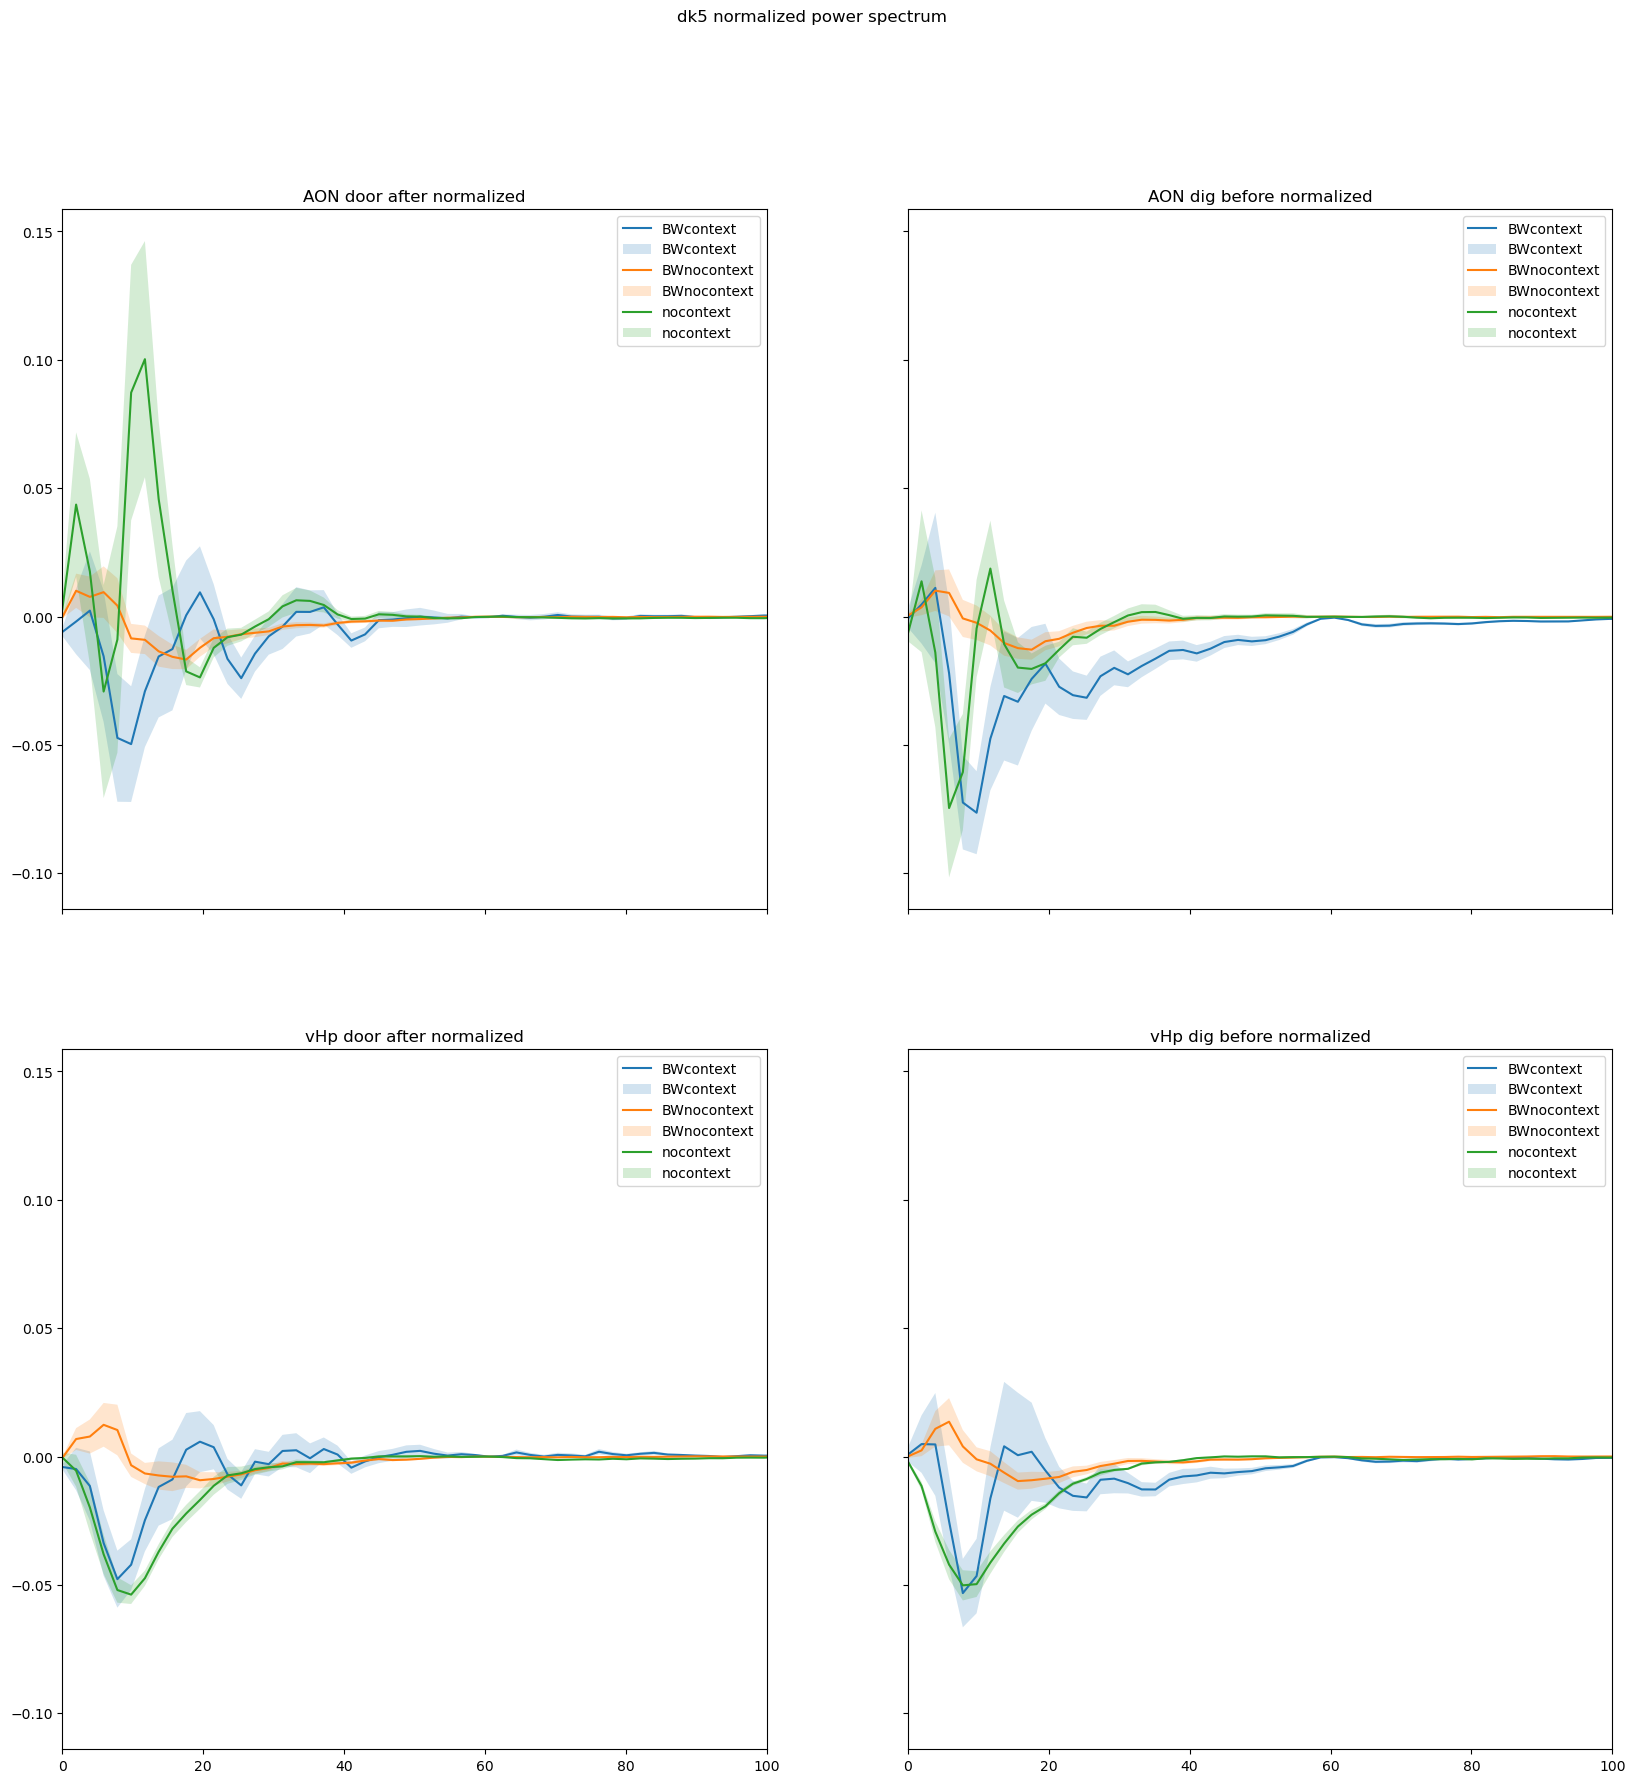

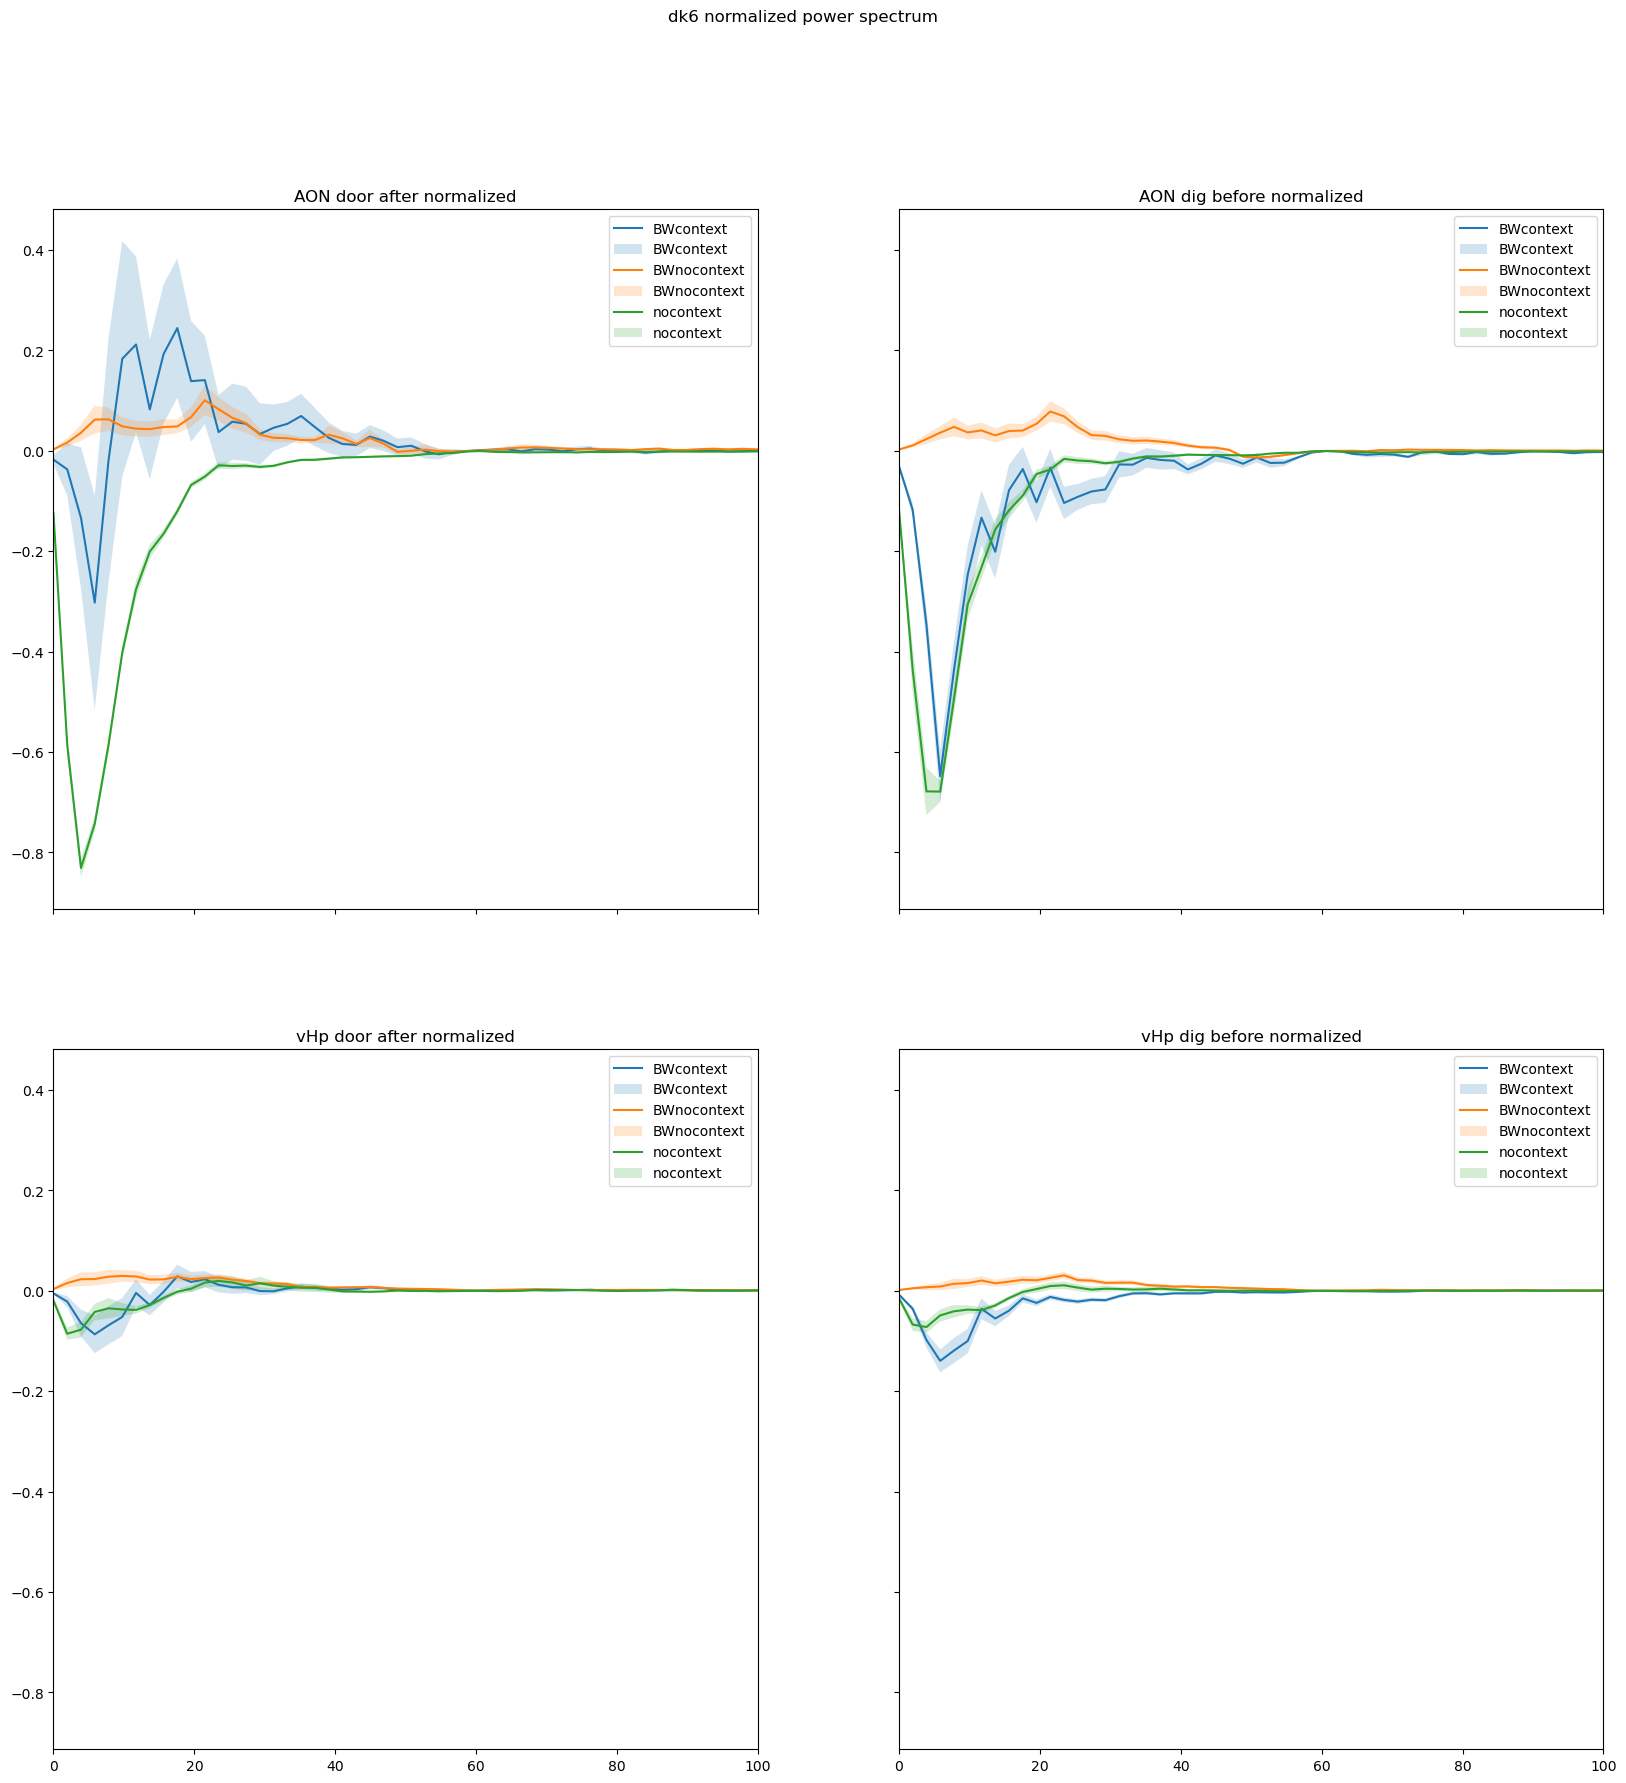

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

brain_areas = ['AON', 'vHp']
rat_ids = np.unique(event_data_compiled_df['rat_id'])
# rat_ids = ['dk1']
events_list = ['door after', 'dig before']

for rat in rat_ids:
    #writer = pd.ExcelWriter(os.path.join(savepath,f'{rat} average power spectrum around events.xlsx'), engine='xlsxwriter')

    rat_data = event_data_compiled_df[event_data_compiled_df['rat_id'] == rat]
    rat_data['channel_id'] = rat_data['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
    rat_data['channel_id'] = rat_data['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )

    # # Calculate door norm by individual
    # rat_data['door norm by ind'] = rat_data['door after'] - rat_data['door before']
    
    # # Calculate the mean of the entire 'door before' column
    # mean_door_before = rat_data['door before'].mean()
    # rat_data['door norm by mean'] = rat_data['door after'] - mean_door_before
    
    fig, axs = plt.subplots(2, 2, figsize=(20, 20), sharey=True, sharex=True)
    fig.suptitle(f'{rat} normalized power spectrum')
    axs = axs.flatten()
    i=0
    for area in brain_areas:
        rat_area_data=rat_data[rat_data['channel_id']==area]
        for event in events_list:
            ax=axs[i]
            tasks = np.unique(rat_area_data['task'])
            ax.set_title(f'{area} {event} normalized')
            for task_num, task_id in enumerate(tasks):    
                task_data = rat_area_data[rat_area_data['task'] == task_id]
                task_data = task_data.reset_index(drop=True)
                if not task_data.empty:
                    task_data_door_before=np.mean(task_data['door before'], axis=0)
                    task_data_after=np.mean(task_data[event], axis=0)
                    task_data_after_normalized=task_data_after-task_data_door_before
                    task_data_after_sem=scipy.stats.sem(task_data[event], axis=0)

                    faxis=np.linspace(0,1000,len(task_data_after_normalized))
                    
                    ax.plot(faxis, task_data_after_normalized, label=f'{task_id}')
                    ax.fill_between(faxis, task_data_after_normalized-task_data_after_sem,task_data_after_normalized+task_data_after_sem,alpha=0.2, label=f'{task_id}')
                    ax.set_xlim(0, 100)
            i=i+1
            ax.legend()
    #writer.close()
    fig.savefig(os.path.join(savepath, f'normalized_power_spectrum_around_events_{rat}.png'),dpi=300, bbox_inches='tight')
    plt.show()

Averaged across all rats, normalized by pre door


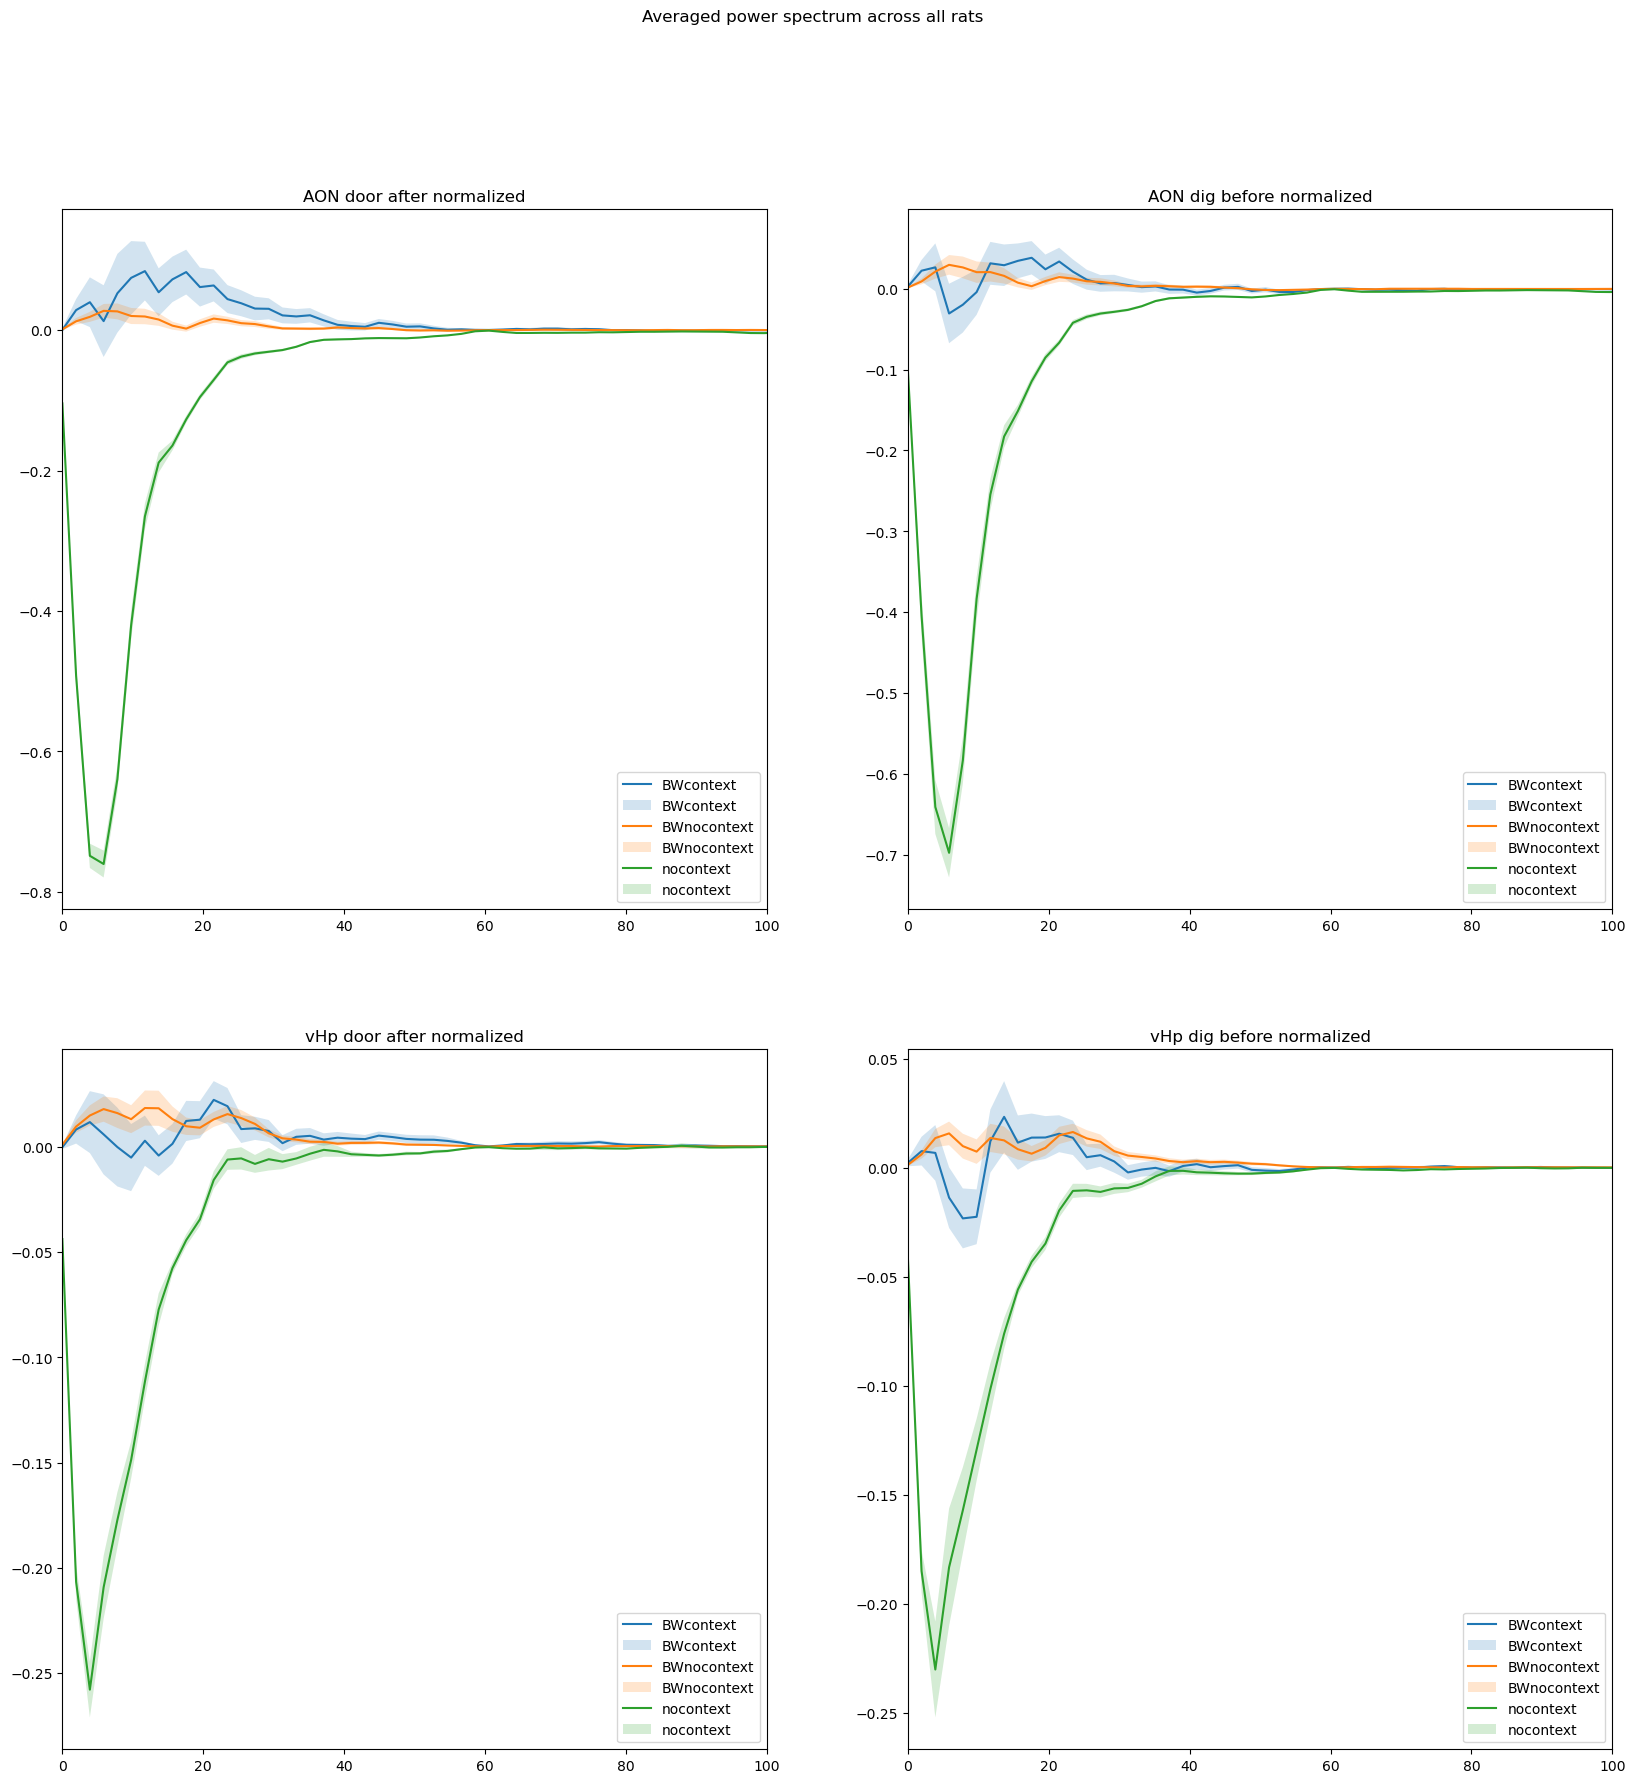

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

brain_areas = ['AON', 'vHp']
rat_ids = np.unique(event_data_compiled_df['rat_id'])
# rat_ids = ['dk1']
events_list = ['door after', 'dig before']

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle(f'Averaged power spectrum across all rats')
axs = axs.flatten()
i=0
rat_data=event_data_compiled_df.copy()

rat_data['channel_id'] = rat_data['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
rat_data['channel_id'] = rat_data['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )

for area in brain_areas:
    rat_area_data=rat_data[rat_data['channel_id']==area]
    for event in events_list:
        ax=axs[i]
        tasks = np.unique(rat_area_data['task'])
        ax.set_title(f'{area} {event} normalized')
        for task_num, task_id in enumerate(tasks):    
            task_data = rat_area_data[rat_area_data['task'] == task_id]
            task_data = task_data.reset_index(drop=True)
            if not task_data.empty:
                task_data_door_before=np.mean(task_data['door before'], axis=0)
                task_data_after=np.mean(task_data[event], axis=0)
                task_data_after_normalized=task_data_after-task_data_door_before
                task_data_after_sem=scipy.stats.sem(task_data[event], axis=0)

                faxis=np.linspace(0,1000,len(task_data_after_normalized))
                
                ax.plot(faxis, task_data_after_normalized, label=f'{task_id}')
                ax.fill_between(faxis, task_data_after_normalized-task_data_after_sem,task_data_after_normalized+task_data_after_sem,alpha=0.2, label=f'{task_id}')
                ax.set_xlim(0, 100)
        i=i+1
        ax.legend()
#writer.close()
fig.savefig(os.path.join(savepath, f'Averaged_power_spectrum_around_events_around_all_rats.png'),dpi=300, bbox_inches='tight')
plt.show()

Now we will make stripplots of power frequencies around each event. We will take a whole experiment, chop the LFP data into pieces around the events. Then calculate the fourier transform. Then we will calculate the power of beta frequencies. Thus one channel in 

In [32]:
def slice_and_sum(row,event):
    event_spec=row[event]
    event_freq=row[event+' freqs']
    deltaf=event_freq[1]-event_freq[0]
    beta_indices=np.where((event_freq>=4) & (event_freq<=10))[0]
    beta_sum=sum(event_spec[beta_indices])*deltaf
    return beta_sum
# Function to perform the specified operations on each row

def process_row(row):
    result = {}
    for event in events_list:
        beta_power=slice_and_sum(row,event)
        result[event]=beta_power
    result['rat_id'] = row['rat_id']
    result['task'] = row['task']
    result['channel_id'] = row['channel_id']
    result['trial'] = row['trial']
    return result

# Apply the function to each row
event_data_compiled_df_processed = event_data_compiled_df.apply(process_row, axis=1, result_type='expand')


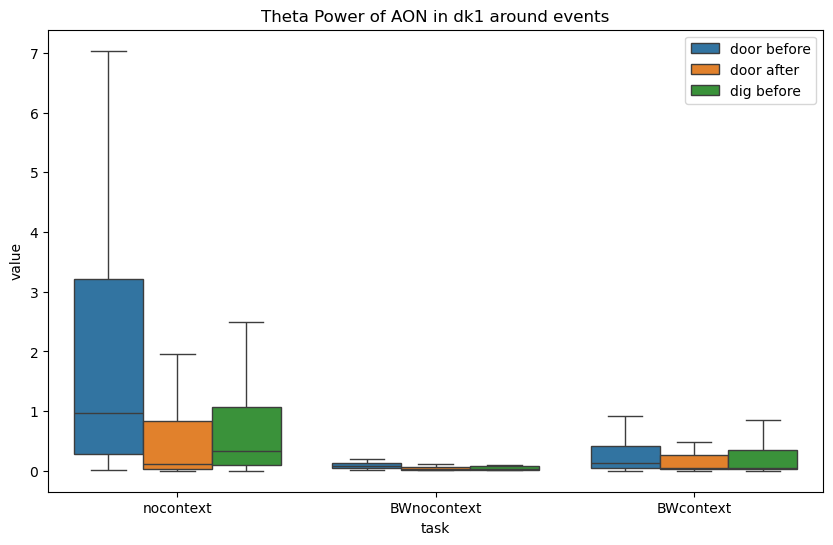

In [34]:
event_data_compiled_df_dk1_aon=event_data_compiled_df_processed[(event_data_compiled_df_processed['channel_id'].str.contains('AON'))&(event_data_compiled_df_processed['rat_id']=='dk1')]

import seaborn as sns
import pandas as pd

# Melt the DataFrame to long format
melted_df = pd.melt(event_data_compiled_df_dk1_aon, id_vars=['task'], value_vars=['door before', 'door after', 'dig before'], var_name='event', value_name='value')
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Theta Power of AON in dk1 around events')

# Create the box plot
sns.boxplot(x='task', y='value', hue='event', data=melted_df, showfliers=False, ax=ax)

# Create the strip plot
#sns.stripplot(x='task', y='value', hue='event', data=melted_df, dodge=True, jitter=True, edgecolor='black', linewidth=1, ax=ax)

# Adjust the legend to avoid duplication
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], labels[0:3])

plt.show()

In [ ]:
print()
x = np.linspace(0, 1000, 513)
z=np.where(x>8)[0][0]

y=np.where(x>12)[0][0]
print(z,y)

### Now I will attempt to make barplots for each rat

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define colorblind-friendly and printer-friendly color scheme
color_scheme = {
    'AON': ['#E69F00', '#56B4E9', '#009E73', '#F0E442'],
    'vHp': ['#0072B2', '#D55E00', '#CC79A7', '#999999']
}

brain_areas = ['AON', 'vHp']
rat_ids = np.unique(averaged_data['rat_id'])
all_rat_total_power=[]
for rat in rat_ids:
    rat_data = averaged_data[averaged_data['rat_id'] == rat]
    tasks = np.unique(rat_data['task'])

    x=np.arange(len(tasks))
    width = 0.25  # the width of the bars
    multiplier = 0
    task_dict={}
    for i, task in enumerate(tasks):
            task_data = rat_data[rat_data['task'] == task]
            task_data = task_data.reset_index(drop=True)
            task_data_vhp = task_data[task_data['channel_id'].str.contains('vHp')]
            task_data_aon = task_data[task_data['channel_id'].str.contains('AON')]
            task_data_vhp = task_data_vhp.reset_index(drop=True)
            task_data_aon = task_data_aon.reset_index(drop=True)
            
            if not task_data_vhp.empty:
                # Ensure all power spectra have the same length
                min_length_vhp = min(len(spectrum) for spectrum in task_data_vhp['average_power_spectrum'])
                task_data_vhp_spectra = [spectrum[:min_length_vhp] for spectrum in task_data_vhp['average_power_spectrum']]
                
                task_data_vhp_mean = np.mean(task_data_vhp_spectra, axis=0)
                task_data_vhp_mean_total_power=np.sum(task_data_vhp_mean)
                print(task_data_vhp_mean_total_power)
                task_data_vhp_spectra=np.array(task_data_vhp_spectra)
                
                faxis=np.linspace(0,1000,num=len(task_data_vhp_mean))

            if not task_data_aon.empty:
                # Ensure all power spectra have the same length
                min_length_aon = min(len(spectrum) for spectrum in task_data_aon['average_power_spectrum'])
                task_data_aon_spectra = [spectrum[:min_length_aon] for spectrum in task_data_aon['average_power_spectrum']]
                task_data_aon_mean = np.mean(task_data_aon_spectra, axis=0)
                task_data_aon_mean_total_power=np.sum(task_data_aon_mean)
                faxis=np.linspace(0,1000,num=len(task_data_aon_mean))
            task_dict[task]=(task_data_vhp_mean_total_power,task_data_aon_mean_total_power)
    # Create a bar plot
    fig, ax = plt.subplots()

    # Extract data for plotting
    tasks = list(task_dict.keys())
    vhp_values = [task_dict[task][0] for task in tasks]
    aon_values = [task_dict[task][1] for task in tasks]

    x = np.arange(len(tasks))  # the label locations
    width = 0.35  # the width of the bars

    rects1 = ax.bar(x - width/2, vhp_values, width, label='vHp', color=color_scheme['vHp'][0])
    rects2 = ax.bar(x + width/2, aon_values, width, label='AON', color=color_scheme['AON'][0])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Tasks')
    ax.set_ylabel('Total Power')
    ax.set_title('Total Power {}'.format(rat))
    ax.set_xticks(x)
    ax.set_xticklabels(tasks)
    ax.legend()

    # Add labels to the bars
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define colorblind-friendly and printer-friendly color scheme
color_scheme = {
    'AON': ['#E69F00', '#56B4E9', '#009E73', '#F0E442'],
    'vHp': ['#0072B2', '#D55E00', '#CC79A7', '#999999']
}

brain_areas = ['AON', 'vHp']
rat_ids = np.unique(averaged_data['rat_id'])
all_rat_total_power=[]
for rat in rat_ids:
    rat_data = averaged_data[averaged_data['rat_id'] == rat]
    tasks = np.unique(rat_data['task'])

    x=np.arange(len(tasks))
    width = 0.25  # the width of the bars
    multiplier = 0
    task_dict={}
    rat_total_power=[]
    
    for i, task in enumerate(tasks):
            task_data = rat_data[rat_data['task'] == task]
            task_data = task_data.reset_index(drop=True)
            task_data_vhp = task_data[task_data['channel_id'].str.contains('vHp')]
            task_data_aon = task_data[task_data['channel_id'].str.contains('AON')]
            task_data_vhp = task_data_vhp.reset_index(drop=True)
            task_data_aon = task_data_aon.reset_index(drop=True)
            
            if not task_data_vhp.empty:
                # Ensure all power spectra have the same length
                min_length_vhp = min(len(spectrum) for spectrum in task_data_vhp['average_power_spectrum'])
                task_data_vhp_spectra = [spectrum[:min_length_vhp] for spectrum in task_data_vhp['average_power_spectrum']]
                
                task_data_vhp_mean = np.mean(task_data_vhp_spectra, axis=0)
                task_data_vhp_mean_total_power=np.sum(task_data_vhp_mean)
                print(task_data_vhp_mean_total_power)
                task_data_vhp_spectra=np.array(task_data_vhp_spectra)
                
                faxis=np.linspace(0,1000,num=len(task_data_vhp_mean))
                gamma=[np.where(faxis>30)[0][0],np.where(faxis>80)[0][0]]
                theta=[np.where(faxis>4)[0][0],np.where(faxis>12)[0][0]]
                beta=[np.where(faxis>12)[0][0],np.where(faxis>30)[0][0]]
                theta_array=task_data_vhp_spectra[:, theta[0]:theta[1]]
                beta_array=task_data_vhp_spectra[:, beta[0]:beta[1]]
                gamma_array=task_data_vhp_spectra[:, gamma[0]:gamma[1]]
                row = pd.DataFrame({
                    'rat': [rat],
                    'task': [task],
                    'area': ['vHp'],
                    'theta': [np.median(theta_array,axis=1)],
                    'beta': [np.median(beta_array,axis=1)],
                    'gamma': [np.median(gamma_array,axis=1)]
                })
            rat_total_power.append(row)

            if not task_data_aon.empty:
                # Ensure all power spectra have the same length
                min_length_aon = min(len(spectrum) for spectrum in task_data_aon['average_power_spectrum'])
                task_data_aon_spectra = [spectrum[:min_length_aon] for spectrum in task_data_aon['average_power_spectrum']]
                task_data_aon_mean = np.mean(task_data_aon_spectra, axis=0)
                task_data_aon_mean_total_power = np.sum(task_data_aon_mean)
                print('aon',task_data_aon_mean_total_power)
                faxis = np.linspace(0, 1000, num=len(task_data_aon_mean))
                task_data_aon_spectra = np.array(task_data_aon_spectra)

                gamma = [np.where(faxis > 30)[0][0], np.where(faxis > 80)[0][0]]
                theta = [np.where(faxis > 4)[0][0], np.where(faxis > 12)[0][0]]
                beta = [np.where(faxis > 12)[0][0], np.where(faxis > 30)[0][0]]
                theta_array=task_data_aon_spectra[:, theta[0]:theta[1]]
                beta_array=task_data_aon_spectra[:, beta[0]:beta[1]]
                gamma_array=task_data_aon_spectra[:, gamma[0]:gamma[1]]
                row = pd.DataFrame({
                    'rat': [rat],
                    'task': [task],
                    'area': ['AON'],
                    'theta': [np.median(theta_array,axis=1)],
                    'beta': [np.median(beta_array,axis=1)],
                    'gamma': [np.median(gamma_array,axis=1)]
                })
            rat_total_power.append(row)
                #row=np.array(row)
    rat_total_power_df = pd.concat(rat_total_power, ignore_index=True)
    bands=['theta','beta','gamma']
    import seaborn as sns
    fig,axs=plt.subplots(1,3,figsize=(20,6))
    fig.suptitle('{}'.format(rat))
    axs=axs.flatten()
    for i,bandi in enumerate(bands):
        ax=axs[i]
        # Explode the 'beta' column to convert lists into individual rows
        band_data = rat_total_power_df[['task', 'area', bandi]].copy()
        band_data_exploded = band_data.explode(bandi)
        band_data_exploded[bandi] = band_data_exploded[bandi].astype(float)
        # Create the boxplot with strip plot
        band_data_exploded = band_data_exploded.dropna(axis=0)

        sns.boxplot(x='task', y=bandi, hue='area', data=band_data_exploded, palette='Set2',showfliers=False,ax=ax)
        sns.stripplot(x='task', y=bandi, hue='area', data=band_data_exploded, dodge=True, jitter=True, color='black', alpha=1,ax=ax,legend='')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_xlabel('Tasks')
        ax.set_ylabel('Total Power dB')
        ax.set_title('Total Power {}'.format(bandi))
        ax.legend(title='Area', loc='upper right')
    fig.tight_layout()
    filename=f'{rat} median power per band'
    fig.savefig(os.path.join(savepath,filename),dpi=300,bbox_inches='tight')

    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
bands=['theta','beta','gamma']

fig,axs=plt.subplots(1,3,figsize=(20,6))
axs=axs.flatten()
for i,bandi in enumerate(bands):
    ax=axs[i]
    # Explode the 'beta' column to convert lists into individual rows
    band_data = rat_total_power_df[['task', 'area', bandi]].copy()
    band_data_exploded = band_data.explode(bandi)
    band_data_exploded[bandi] = band_data_exploded[bandi].astype(float)
    # Create the boxplot with strip plot

    sns.boxplot(x='task', y=bandi, hue='area', data=band_data_exploded, palette='Set2',showfliers=False,ax=ax)
    sns.stripplot(x='task', y=bandi, hue='area', data=band_data_exploded, dodge=True, jitter=True, color='black', alpha=1,ax=ax,legend='')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Tasks')
    ax.set_ylabel('Total Power dB')
    ax.set_title('Total Power {}'.format(bandi))
    ax.legend(title='Area', loc='upper right')

plt.tight_layout()
plt.show()

In [86]:
import seaborn as sns

# load the dataframe
tips = sns.load_dataset('tips')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define colorblind-friendly and printer-friendly color scheme
color_scheme = {
    'AON': ['#E69F00', '#56B4E9', '#009E73', '#F0E442'],
    'vHp': ['#0072B2', '#D55E00', '#CC79A7', '#999999']
}

# Assuming rat_total_power_df is already defined and contains the necessary data
# Aggregate the beta values by taking the mean
rat_total_power_df['beta_mean'] = rat_total_power_df['beta'].apply(lambda x: np.mean(x))

fig, ax = plt.subplots()

tasks = np.unique(rat_total_power_df['task'])
x = np.arange(len(tasks))

aon_values = rat_total_power_df[rat_total_power_df['area'] == 'AON']
vhp_values = rat_total_power_df[rat_total_power_df['area'] == 'vHp']

# Prepare data for boxplot
data_vhp = [vhp_values[vhp_values['task'] == task]['beta_mean'].values for task in tasks]
data_aon = [aon_values[aon_values['task'] == task]['beta_mean'].values for task in tasks]

# Create boxplots
box_vhp = ax.boxplot(data_vhp, positions=x - 0.2, widths=0.35, patch_artist=True, boxprops=dict(facecolor=color_scheme['vHp'][0]), labels=tasks)
box_aon = ax.boxplot(data_aon, positions=x + 0.2, widths=0.35, patch_artist=True, boxprops=dict(facecolor=color_scheme['AON'][0]), labels=tasks)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Tasks')
ax.set_ylabel('Total Power (Beta Mean)')
ax.set_title('Total Power by Task and Brain Area')
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.legend([box_vhp["boxes"][0], box_aon["boxes"][0]], ['vHp', 'AON'], loc='upper right')

fig.tight_layout()

plt.show()

In [ ]:
print(task_dict.items())

In [ ]:
print(np.where(faxis>6))